In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as pyoff
import plotly.graph_objs as go
import time
from datetime import datetime
from datetime import datetime as dt
import numpy as np
import plotly.express as px
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score,mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import mglearn
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from fbprophet import Prophet
import pystan

• FG_avg (en W=m2) : le flux global\
• FD_avg (en W=m2) : le flux diffus\
• Patm_avg (en hPa) : la pression atmosphérique\
• RH_avg (en %) : le taux d’humidité dans l’air\
• Text_avg (en °C) : la température extérieure\
• WD_MeanUnitVector (en degré) : la direction du vent\
• WS_avg (en m/s) : la vitesse du vent\

In [2]:
df1 = pd.read_csv('moufia_2014_2015.csv')
df1['Kb'] = (df1['FG_Avg']-df1['FD_Avg'])/df1['FG_Avg']
df1.tail()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


,Timestamp,FD_Avg,FG_Avg,Patm_Avg,RH_Avg,Text_Avg,WD_MeanUnitVector,WS_Mean,Kb
1023576,2015-12-30 23:56:00,5.336,1.249,973.7166,62.86666,22.85,127.8547,6.300000,-3.272218
1023577,2015-12-30 23:57:00,0.681,6.017,973.7166,62.25000,22.80,109.0756,4.383334,0.886821
1023578,2015-12-30 23:58:00,5.336,5.506,973.7166,62.66666,22.90,112.6669,4.450000,0.030875
1023579,2015-12-30 23:59:00,3.009,5.847,973.6833,62.84999,22.90,119.5639,4.483333,0.485377
1023580,2015-12-31 00:00:00,3.122,1.419,973.6333,62.58333,22.80,123.5123,4.616667,-1.200141


Nous allons prédire l'indice de fraction dire 
$$Kb = \frac{FD - FG}{FG}$$

In [3]:
df1.isnull().sum()

Timestamp            0
FD_Avg               0
FG_Avg               0
Patm_Avg             0
RH_Avg               0
Text_Avg             0
WD_MeanUnitVector    0
WS_Mean              0
Kb                   0
dtype: int64

In [4]:
df1.describe()

,FD_Avg,FG_Avg,Patm_Avg,RH_Avg,Text_Avg,WD_MeanUnitVector,WS_Mean,Kb
count,1.023581e+06,1.023581e+06,1.023581e+06,1.023581e+06,1.023581e+06,1.023581e+06,1.023581e+06,1.023581e+06
mean,1.032886e+02,2.358068e+02,9.775750e+02,6.589080e+01,2.259144e+01,1.514509e+02,3.106031e+00,5.672416e-02
std,1.864244e+02,3.826888e+02,4.149622e+00,9.731939e+00,2.432603e+00,8.106752e+01,2.009497e+00,1.921106e+00
min,6.800000e-01,-1.434000e+02,9.562000e+02,2.658333e+01,1.600000e+01,0.000000e+00,0.000000e+00,-1.574439e+03
25%,3.178000e+00,3.631000e+00,9.750999e+02,5.941667e+01,2.070000e+01,8.900111e+01,1.616667e+00,9.055982e-03
50%,1.085000e+01,1.067000e+01,9.777000e+02,6.564999e+01,2.270000e+01,1.269201e+02,2.550000e+00,1.650552e-01
75%,1.283000e+02,3.556000e+02,9.807666e+02,7.230000e+01,2.435000e+01,2.210032e+02,4.250000e+00,6.677031e-01
max,1.553000e+03,2.470000e+03,9.870999e+02,9.269999e+01,3.140000e+01,3.599991e+02,2.006667e+01,3.978310e+02


In [3]:
##Suppression des valeurs aberrantes 
df1 = df1.loc[df1['Kb'] >= 0.0] 
df1 = df1.loc[df1['Kb'] <= 1.0] 
df1.shape

(786171, 9)

In [4]:
df1['date'] = pd.to_datetime(df1['Timestamp']).dt.date
df1['date']  = pd.to_datetime(df1['date'])
df1['date'] = df1['date'].dt.strftime('%Y')
df1

,Timestamp,FD_Avg,FG_Avg,Patm_Avg,RH_Avg,Text_Avg,WD_MeanUnitVector,WS_Mean,Kb,date
1,2014-01-01 00:01:00,1.361,4.084,973.1667,68.71667,24.58333,94.43468,3.750000,0.666748,2014
2,2014-01-01 00:02:00,3.574,6.297,973.1500,68.83333,24.51666,97.81310,5.583333,0.432428,2014
4,2014-01-01 00:04:00,1.588,6.524,973.0999,69.33334,24.50000,98.83556,4.650000,0.756591,2014
5,2014-01-01 00:05:00,3.574,4.311,973.0667,69.23333,24.50000,101.17740,6.366667,0.170958,2014
6,2014-01-01 00:06:00,3.801,4.425,973.0833,69.46667,24.50000,88.85400,4.716667,0.141017,2014
...,...,...,...,...,...,...,...,...,...,...
1023571,2015-12-30 23:51:00,0.681,5.336,973.7333,60.71666,22.98333,124.81530,7.633333,0.872376,2015
1023575,2015-12-30 23:55:00,3.009,3.236,973.7666,62.84999,22.96667,111.10150,4.616667,0.070148,2015
1023577,2015-12-30 23:57:00,0.681,6.017,973.7166,62.25000,22.80000,109.07560,4.383334,0.886821,2015
1023578,2015-12-30 23:58:00,5.336,5.506,973.7166,62.66666,22.90000,112.66690,4.450000,0.030875,2015


## Box Plot

In [5]:
#fig = px.box(df1,y= 'Kb', color = 'date')
#fig.show()

In [ ]:
fig1, ax1 = plt.subplots()
#df2 = df1.reset_index()
df2= df1[['Timestamp','Kb']]
ax1.set_title('Basic Plot')
ax1.boxplot(df2)

In [ ]:
df1['date'] = pd.to_datetime(df1['Timestamp']).dt.date
df1['date']  = pd.to_datetime(df1['date'])
df1['date'] = df1['date'].dt.strftime('%Y')

In [23]:
df1['Date'] = pd.to_datetime(df1['Timestamp'])
df1.index = df1['Date'] 
df2 = df1.resample('Y').mean() # on fait la moyenne sur chaque jour
#df1['date'] = pd.to_datetime(df1['Timestamp']).dt.date
#df1['date']  = pd.to_datetime(df1['Date'])
#df2['date'] = df2['Date'].dt.strftime('%Y')
#df2 = df2.fillna(df2.mean()) # on remplace les valeurs manquantes par la moyenne entre deux variables ou il situe la valeur NaN
#df2 = df2[['Date','Kb']]
df2 = df2.reset_index()
df2

,Date,FD_Avg,FG_Avg,Patm_Avg,RH_Avg,Text_Avg,WD_MeanUnitVector,WS_Mean,Kb
0,2014-12-31,153.330437,351.331250,977.531899,64.617012,22.963930,140.589973,3.261846,0.428996
1,2015-12-31,104.176932,253.009446,977.468859,66.218946,22.864743,147.673006,3.259263,0.408269


In [41]:
df2['date'] = pd.to_datetime(df2['Date']).dt.date
df2['date']  = pd.to_datetime(df2['date'])
df2['date'] = df2['date'].dt.strftime('%Y')
df4 = df2[['date','Kb']]
df4.Kb.astype(str)
df4[''.astype(str)

0    2014
1    2015
Name: date, dtype: object

### Corrélation de moufia

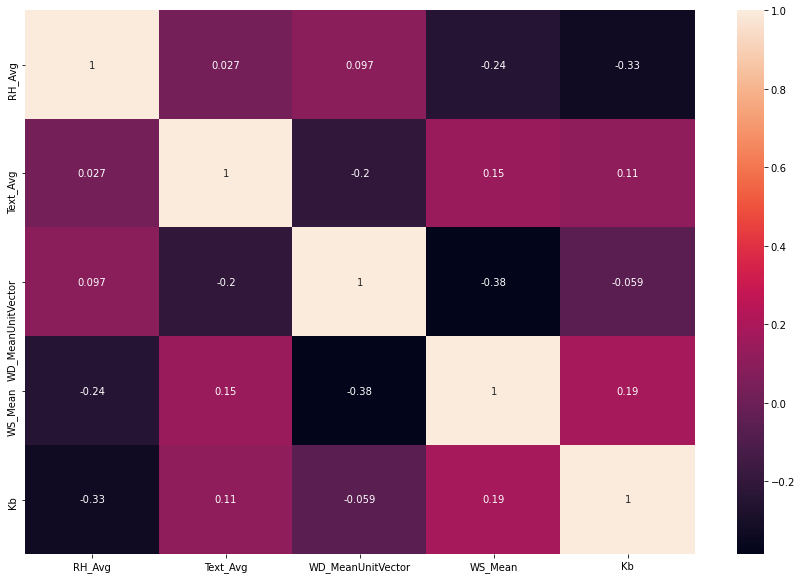

In [9]:
df1_mouf = df1.drop(['FD_Avg', 'FG_Avg', 'Patm_Avg'], axis =1)
corrMatrix = df1_mouf.corr()
plt.figure(figsize=(15,10))
sn.heatmap(corrMatrix, annot=True)
plt.show()

## train test split

In [10]:
df1['Date'] = pd.to_datetime(df1['Timestamp'])
df1.index = df1['Date'] 
df = df1.resample('H').mean() # on fait la moyenne sur chaque heure
#df_mouf = df.resample('D').mean() # on fait la moyenne sur chaque jour
df_tr =df.fillna(df.mean()) # on remplace els valeurs manquantes par la moyenne entre deux variables ou il situe la valeur NaN
X1 = df_tr[['FD_Avg', 'FG_Avg', 'Patm_Avg', 'RH_Avg', 'Text_Avg',
       'WD_MeanUnitVector', 'WS_Mean']]
y1 = df_tr['Kb']

In [11]:
'''
X1 = df1[['FD_Avg', 'FG_Avg', 'Patm_Avg', 'RH_Avg', 'Text_Avg',
       'WD_MeanUnitVector', 'WS_Mean']]
y1 = df1['Kb']'''

"\nX1 = df1[['FD_Avg', 'FG_Avg', 'Patm_Avg', 'RH_Avg', 'Text_Avg',\n       'WD_MeanUnitVector', 'WS_Mean']]\ny1 = df1['Kb']"

In [12]:
X_train1, X_test1, y_train1, y_test1 = tts(X1,y1, test_size=0.25, random_state=0)

## Régression linéaire

In [13]:
lm_mouf = LinearRegression()
lm_mouf.fit(X_train1, y_train1)

LinearRegression()

In [14]:
# Evaluation de l'ensemble d'apprentissage
from sklearn.metrics import r2_score
y_pred_mouf = lm_mouf.predict(X_train1)
rmse = (np.sqrt(mse(y_train1, y_pred_mouf)))
r2 = r2_score(y_train1, y_pred_mouf)
 
print('La performance du modèle sur lensemble dapprentissage')
print('--------------------------------------')
print('erreur quadratique moyenne est {:.2f}'.format(rmse))
print('le score R2 est {:.2f}'.format(r2))
print('\n')

La performance du modèle sur lensemble dapprentissage
--------------------------------------
erreur quadratique moyenne est 0.12
le score R2 est 0.73




In [15]:
# Evaluation de l'ensemble de test
from sklearn.metrics import r2_score
y_pred_mouf_test = lm_mouf.predict(X_test1)
rmse_test = (np.sqrt(mse(y_test1, y_pred_mouf_test)))
r2_test = r2_score(y_test1, y_pred_mouf_test)
 
print('La performance du modèle sur lensemble dapprentissage')
print('--------------------------------------')
print('erreur quadratique moyenne est {:.2f}'.format(rmse_test))
print('le score R2 est {:.2f}'.format(r2_test))
print('\n')

La performance du modèle sur lensemble dapprentissage
--------------------------------------
erreur quadratique moyenne est 0.12
le score R2 est 0.71




# Clustring
## Kmeans

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X1)

In [17]:
kmeans = KMeans(n_clusters=3,init='k-means++', max_iter=300, n_init=10, random_state=0).fit(X_train1)
'''kmeans.labels_
kmeans.inertia_
kmeans.cluster_centers_'''

'kmeans.labels_\nkmeans.inertia_\nkmeans.cluster_centers_'

In [18]:
# On affiche les 100 premiers adhésions
print("Adhésions au cluster :\n{}".format(kmeans.labels_[0:100]))

Adhésions au cluster :
[0 0 0 1 0 0 1 0 1 0 1 2 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1]


Comme nous avons demandé trois clusters, les clusters sont numérotés de 0 à 2.

In [19]:
print("centres des clusters :\n{}".format(kmeans.cluster_centers_))

centres des clusters :
[[  34.82337266   55.60705696  977.63410173   67.20787793   21.95750709
   167.46104854    2.58162441]
 [ 233.94440846  651.63192657  977.69228445   61.80214088   24.29932464
   106.08524794    4.53917749]
 [1101.32817623 1934.90446003  975.30870977   67.30140837   25.21072583
   127.0404013     3.13026074]]


In [20]:
y_pred_km = kmeans.predict(X_train1)
print(y_pred_km[0:100])

[0 0 0 1 0 0 1 0 1 0 1 2 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1]


In [21]:
'''plt.scatter(X_scaled[y_pred_km==0,0],X_scaled[y_pred_km==0,1],s=50, c='purple',label='Cluster1')
plt.scatter(X_scaled[y_pred_km==1,0],X_scaled[y_pred_km==1,1],s=50, c='blue',label='Cluster2')
plt.scatter(X_scaled[y_pred_km==2,0],X_scaled[y_pred_km==2,1],s=50, c='green',label='Cluster3')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],s=200,marker='s', c='red', alpha=0.7, label='Centroids')
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()'''

"plt.scatter(X_scaled[y_pred_km==0,0],X_scaled[y_pred_km==0,1],s=50, c='purple',label='Cluster1')\nplt.scatter(X_scaled[y_pred_km==1,0],X_scaled[y_pred_km==1,1],s=50, c='blue',label='Cluster2')\nplt.scatter(X_scaled[y_pred_km==2,0],X_scaled[y_pred_km==2,1],s=50, c='green',label='Cluster3')\nplt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],s=200,marker='s', c='red', alpha=0.7, label='Centroids')\nplt.title('')\nplt.xlabel('')\nplt.ylabel('')\nplt.legend()\nplt.show()"

Text(0.5, 1.0, 'Affectations de cluster et centres de cluster trouvés par k-means avec trois clusters')

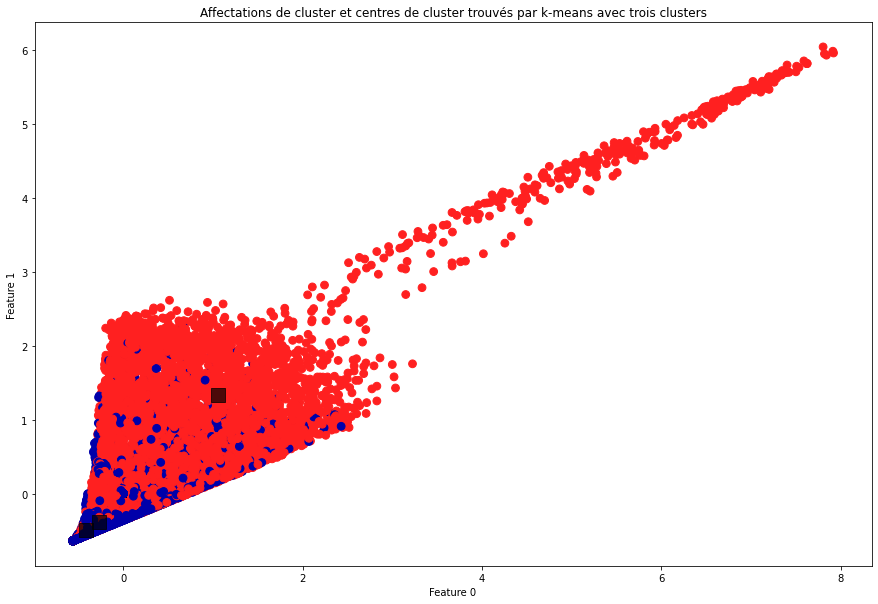

In [22]:
#Visualisation
#import mglearn
cl = kmeans.fit_predict(X_scaled)
# plot the cluster assignments
plt.figure(figsize=(15,10))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cl, cmap=mglearn.cm2, s=60)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],s=200,marker='s', c='black', alpha=0.7, label='Centroids')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title('Affectations de cluster et centres de cluster trouvés par k-means avec trois clusters')

## DBSCAN  

In [23]:
from sklearn.cluster import DBSCAN

In [24]:
db = DBSCAN(eps=0.3, min_samples=10)
db.fit(X_train1)

DBSCAN(eps=0.3, min_samples=10)

In [25]:
db.labels_[10:30]
#print(db.core_sample_indices_)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1], dtype=int64)

In [26]:
clusters = db.fit_predict(X_train1)
print("Cluster memberships:\n{}".format(clusters))

Cluster memberships:
[-1 -1 -1 ... -1 -1 -1]


In [27]:
#print("Accuracy: {:.2f}".format(accuracy_score(y_train1, clusters)))

AttributeError: 'DBSCAN' object has no attribute 'cluster_centers_'

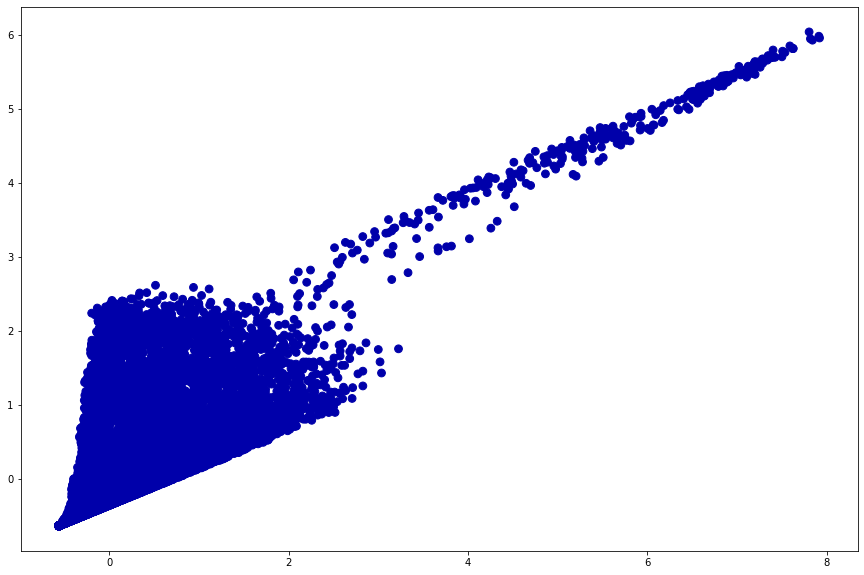

In [28]:
clusters = db.fit_predict(X_scaled)
# plot the cluster assignments
plt.figure(figsize=(15,10))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm2, s=60)
plt.scatter(kmeans.cluster_centers_[:,0], db.cluster_centers_[:,1],s=200,marker='s', c='black', alpha=0.7, label='Centroids')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

# Séries Temporelles

In [6]:
df1['Date'] = pd.to_datetime(df1['Timestamp'])
df1.index = df1['Date'] 
df = df1.resample('H').mean() # on fait la moyenne sur chaque heure
df_mouf = df.resample('D').mean() # on fait la moyenne sur chaque jour
df_mouf =df_mouf.fillna(df.mean()) # on remplace els valeurs manquantes par la moyenne entre deux variables ou il situe la valeur NaN
df_mouf

,FD_Avg,FG_Avg,Patm_Avg,RH_Avg,Text_Avg,WD_MeanUnitVector,WS_Mean,Kb
Date,,,,,,,,
2014-01-01,485.771451,826.248863,971.854427,67.283118,24.695465,123.586120,4.755223,0.307910
2014-01-02,103.463365,238.582731,977.623909,65.809696,22.595046,151.069589,3.088802,0.405691
2014-01-03,103.463365,238.582731,977.623909,65.809696,22.595046,151.069589,3.088802,0.405691
2014-01-04,794.112952,1404.436286,970.175328,72.265004,24.904224,285.862586,4.244820,0.435388
2014-01-05,826.284167,1493.985556,972.751702,70.135010,24.889733,118.966780,2.872488,0.482968
...,...,...,...,...,...,...,...,...
2015-12-26,112.280760,305.775875,975.601858,58.996746,25.406857,110.749722,3.996122,0.472983
2015-12-27,70.330828,299.244599,975.489452,60.659210,25.289473,116.266578,3.864780,0.509890
2015-12-28,105.676576,230.939390,976.986662,61.132580,25.253357,126.287849,3.046923,0.428230


In [7]:
df_mouf.isna().sum()

FD_Avg               0
FG_Avg               0
Patm_Avg             0
RH_Avg               0
Text_Avg             0
WD_MeanUnitVector    0
WS_Mean              0
Kb                   0
dtype: int64

aucune valeur manquante

# Visualisations de masses de données de séries temporelles

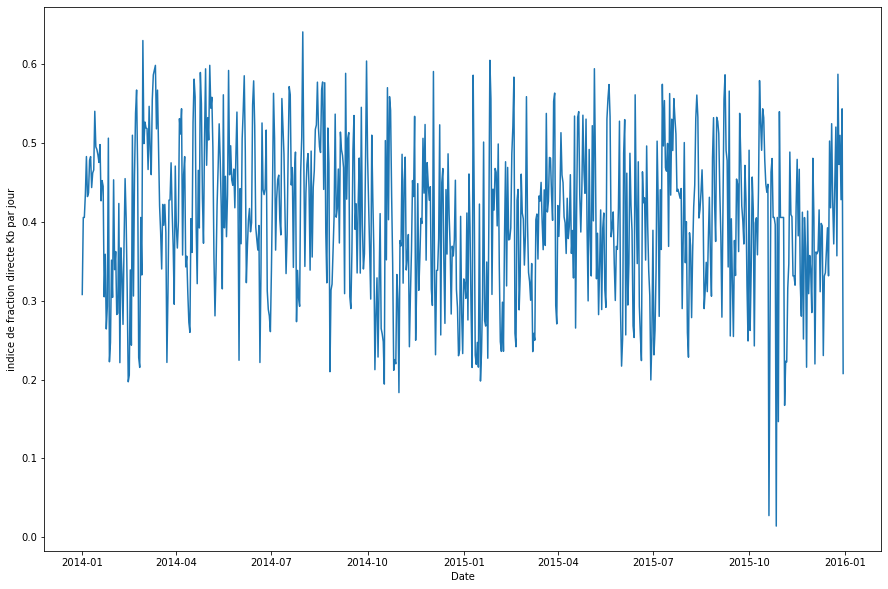

In [8]:
plt.figure(figsize=(15,10))
plt.xlabel('Date')
plt.ylabel('indice de fraction directe Kb par jour')
plt.plot(df_mouf['Kb'])

Avant de pouvoir construire un modèle de prévision, nous devons nous assurer que la série temporelle est stationnaire.
Une façon de déterminer si une série temporelle donnée est stationnaire:

Statistiques roulantes : Tracer la moyenne mobile et l’écart-type mobile. La série temporelle est stationnaire si elle reste constante dans le temps (à l’œil nu, regardez si les lignes sont droites et parallèles à l’axe des x)

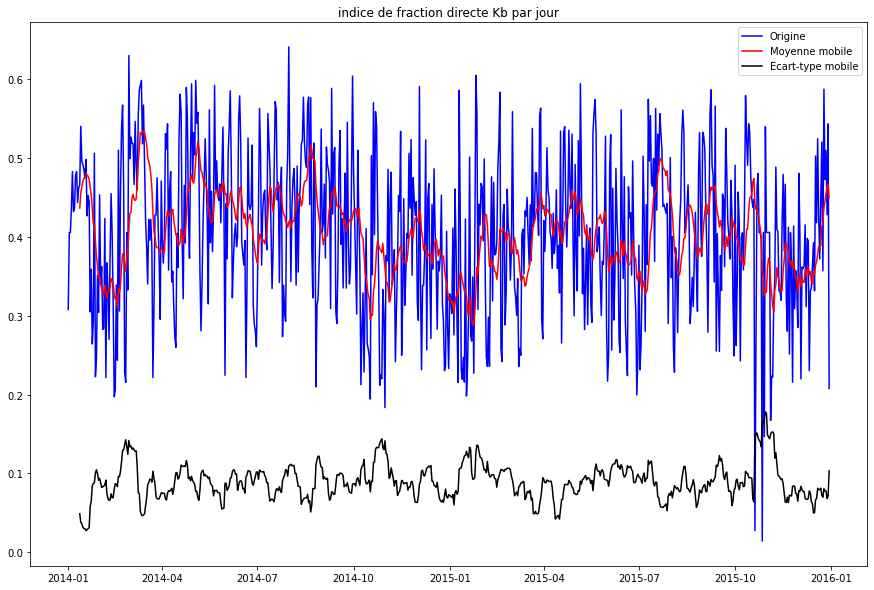

In [9]:
rolling_mean = df_mouf['Kb'].rolling(window = 12).mean()
rolling_std = df_mouf['Kb'].rolling(window = 12).std()
plt.figure(figsize=(15,10))
plt.plot(df_mouf['Kb'], color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
plt.legend(loc = 'best')
plt.title('indice de fraction directe Kb par jour')
plt.show()

Comme vous pouvez le voir, la moyenne mobile et l’écart-type mobile de l'indice de fraction directe Kb restent stationaire avec le temps, Nous pouvons donc dire que la série temporelle est stationnaire.  

In [10]:
mdl = sm.tsa.statespace.SARIMAX(df_mouf['Kb'],order=(0, 0, 0),seasonal_order=(2, 2, 1, 7),enforce_stationarity=True,enforce_invertibility=True)
res = mdl.fit()
print(res.summary())

                                 SARIMAX Results                                 
Dep. Variable:                        Kb   No. Observations:                  729
Model:             SARIMAX(2, 2, [1], 7)   Log Likelihood                 514.173
Date:                   Thu, 06 May 2021   AIC                          -1020.346
Time:                           00:51:40   BIC                          -1002.057
Sample:                       01-01-2014   HQIC                         -1013.283
                            - 12-30-2015                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.6142      0.035    -17.416      0.000      -0.683      -0.545
ar.S.L14      -0.3416      0.038     -8.946      0.000      -0.416      -0.267
ma.S.L7       -1.0000     52

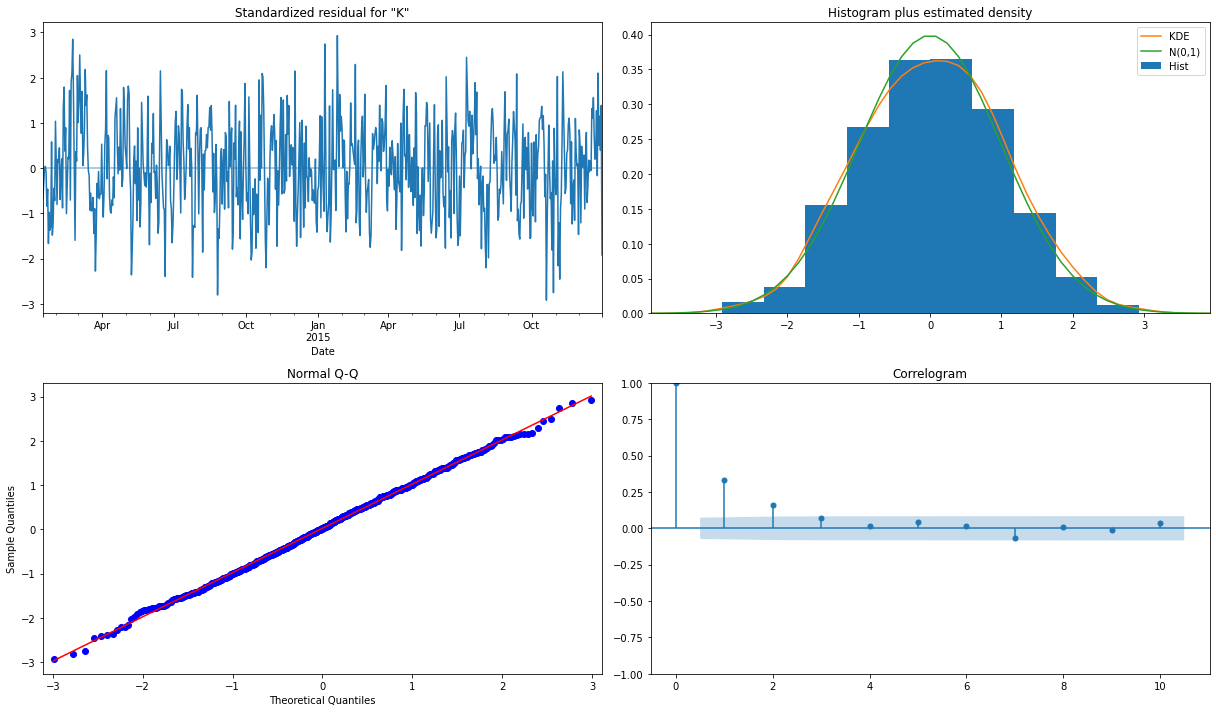

In [11]:
res.plot_diagnostics(figsize=(17, 10))
plt.tight_layout()
plt.show()

# prédiction de l’indice Kb de fraction directe à l’horizon H+1, H+2, …, J+1, J+2…

## Modèle de la Moyenne Mobile Auto-Régressive Intégrée (ARIMA)

C:\Users\Etudiant\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


C:\Users\Etudiant\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\Etudiant\anaconda3\lib\site-packages\stats

<Figure size 1800x720 with 0 Axes>

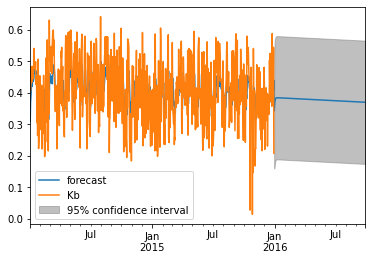

<Figure size 2520x720 with 0 Axes>

In [12]:
decomposition = seasonal_decompose(df_mouf['Kb']) 
model = ARIMA(df_mouf['Kb'], order=(2,1,2))
results = model.fit(disp=-1)
plt.figure(figsize=(25,10))
results.plot_predict(1,1000)
plt.figure(figsize=(35,10))
plt.show()

## Facebook Prophet

In [ ]:
data_mouf = df_mouf.reset_index()

Nous n'avons besoin que les deux colonnes de notre ensemble de données (Date et Kb).\
Nous créons donc un nouveau Dataframe uniquement pour ces deux colonnes

In [ ]:
data_mouf = data_mouf[['Date','Kb']]

Comme nous utilisons le modèle de 'Facebook Prophet' ici pour prédire l'indice de fraction directe, nous devons renommer les colonnes

In [ ]:
data_mouf = data_mouf.rename(columns={'Date':'ds', 'Kb':'y'})
data_mouf

In [ ]:
model = Prophet()
model.fit(data_mouf)
predict = model.make_future_dataframe(periods=365)
forecast = model.predict(predict)
predict.tail()